In [24]:
import os
import pandas as pd
import numpy as np
import pickle
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
city = 'paris'
db = 1
OC = 1.5

In [26]:
directory = '../../raw_results'
file_names = os.listdir(directory)

# https://www.gurobi.com/documentation/current/refman/optimization_status_codes.html
status_map = {2: 'optimal', 9: 'time_limit', 11: 'interrumpted'}

results = []

for i in range(len(file_names)):
    results_file = f'{directory}/{file_names[i]}'
    with open(results_file, 'rb') as file:
        sol = pickle.load(file)
    keys = file_names[i].split('_')
    final_sol = {
        'city': keys[0],
        'db': keys[1].replace('db=', ''),
        'OC': keys[2].replace('OC=', ''),
        'model': keys[3].replace('model=', '').replace('.pkl', ''),
        'max_n_shifts': keys[-1].replace('shifts=', '').replace('.pkl', '') if 'shifts' in keys[-1] else "",
        'obj_val': sol['obj_val'], 
        'status': status_map[sol['status']], 
        'gap': np.round(float(sol['gap']) * 100, 2),
        'workforce_size': len(sol['U'])
    }
    results.append(final_sol)

results_df = pd.DataFrame(results)
results_df['model_'] = results_df['model'] + results_df['max_n_shifts']
results_df = results_df.query(f'city == "{city}"').sort_values(['db', 'OC', 'model'])

model_results = pd.pivot_table(results_df, index=['city', 'db', 'OC'], values='obj_val', columns='model_').astype(int)
model_results

model_          fixed    flex  partflex2  partflex3  partflex4
city  db   OC                                                 
paris 0.50 1.2   3552    3168       3552       3168       3168
           1.5   3768    3272       3768       3272       3272
           1.8   3855    3452       3855       3452       3452
           2.0   4097    3565       4097       3565       3565
           2.5   4143    3717       4143       3717       3717
      1.00 1.2   6684    5623       6684       5623       5623
           1.5   7013    5956       7013       5956       5956
           1.8   7321    6189       7321       6189       6189
           2.0   7480    6294       7480       6294       6294
           2.5   7812    6715       7812       6715       6715
      2.00 1.2  12969   11011      12969      11011      11011
           1.5  13676   11609      13676      11609      11609
           1.8  14231   12033      14231      12033      12033
           2.0  14616   12440      14616      12440      12440
           2.5  15396   13305      15396      13305      13305
      4.00 1.2  25363   68578      25363      68578      68578
           1.5  26799   38489      26799      38489      38489
           1.8  27863   71499      27863      71499      71499
           2.0  28555  101947      28555     101947     101947
           2.5  29865  134974      29865     134974     134974

In [27]:
model_results.query('fixed < partflex3')

model_          fixed    flex  partflex2  partflex3  partflex4
city  db   OC                                                 
paris 4.00 1.2  25363   68578      25363      68578      68578
           1.5  26799   38489      26799      38489      38489
           1.8  27863   71499      27863      71499      71499
           2.0  28555  101947      28555     101947     101947
           2.5  29865  134974      29865     134974     134974

In [28]:
model_results.query('fixed < partflex4')

model_          fixed    flex  partflex2  partflex3  partflex4
city  db   OC                                                 
paris 4.00 1.2  25363   68578      25363      68578      68578
           1.5  26799   38489      26799      38489      38489
           1.8  27863   71499      27863      71499      71499
           2.0  28555  101947      28555     101947     101947
           2.5  29865  134974      29865     134974     134974

In [29]:
directory = '../../raw_results'
file_names = [file for file in os.listdir(directory) if f'{city}_db={db}.00_OC={OC}' in file]
file_names

['paris_db=1.00_OC=1.5_model=partflex_max_n_shifts=3.pkl',
 'paris_db=1.00_OC=1.5_model=partflex_max_n_shifts=2.pkl',
 'paris_db=1.00_OC=1.5_model=flex.pkl',
 'paris_db=1.00_OC=1.5_model=partflex_max_n_shifts=4.pkl',
 'paris_db=1.00_OC=1.5_model=fixed.pkl']

In [30]:
solution_file = 'paris_db=1.00_OC=1.5_model=partflex_max_n_shifts=3.pkl'
with open(f'{directory}/{solution_file}', 'rb') as file:
    solution = pickle.load(file)
solution.keys()

area_assignment = [ (key[0], key[1], key[2], key[3]) for key, value in solution['k'].items() ]
area_assignment_df = pd.DataFrame(area_assignment, columns=['employee', 'area_id', 'period', 'day'])
area_period_summary = area_assignment_df.groupby(['area_id', 'day', 'period']).count().reset_index()
area_period_summary['day_period'] = area_period_summary['day'].astype(str) + '\n' + area_period_summary['period'].astype(str)

In [31]:
def data_prepare(solution):
    area_assignment = [ (key[0], key[1], key[2], key[3]) for key, value in solution['k'].items() ]
    area_assignment_df = pd.DataFrame(area_assignment, columns=['employee', 'area_id', 'period', 'day'])
    area_period_summary = area_assignment_df.groupby(['area_id', 'day', 'period']).count().reset_index()
    #area_period_summary['day_period'] = area_period_summary['day'].astype(str) + '\n' + area_period_summary['period'].astype(str)
    area_period_summary['day_period'] = area_period_summary['day'].astype(str) + '-' + area_period_summary['period'].astype(str)

    return area_period_summary

In [32]:
def plot_area_periods(solution_file, area_period_summary):
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(30,10))

    pt = pd.pivot(area_period_summary, index="area_id", columns='day_period', values="employee")
    sns.heatmap(pt, annot=True, ax=axs, cbar=False, cmap='Blues')

    model_ = solution_file.split('model=')[1]
    if 'max_n' in model_:
        title = model_.split('_max')[0].split('.')[0].upper() + f' (max number of shifts = { model_.split("max_n_shifts=")[1].replace(".pkl","") })'
    else:
        title = model_.split('_max')[0].split('.')[0].upper()

    axs.set_title(title, fontsize=16)
    axs.set_ylabel('Areas', fontsize=16)
    axs.set_xlabel('Time', fontsize=16)
    plt.yticks(rotation=0)

    plt.show()

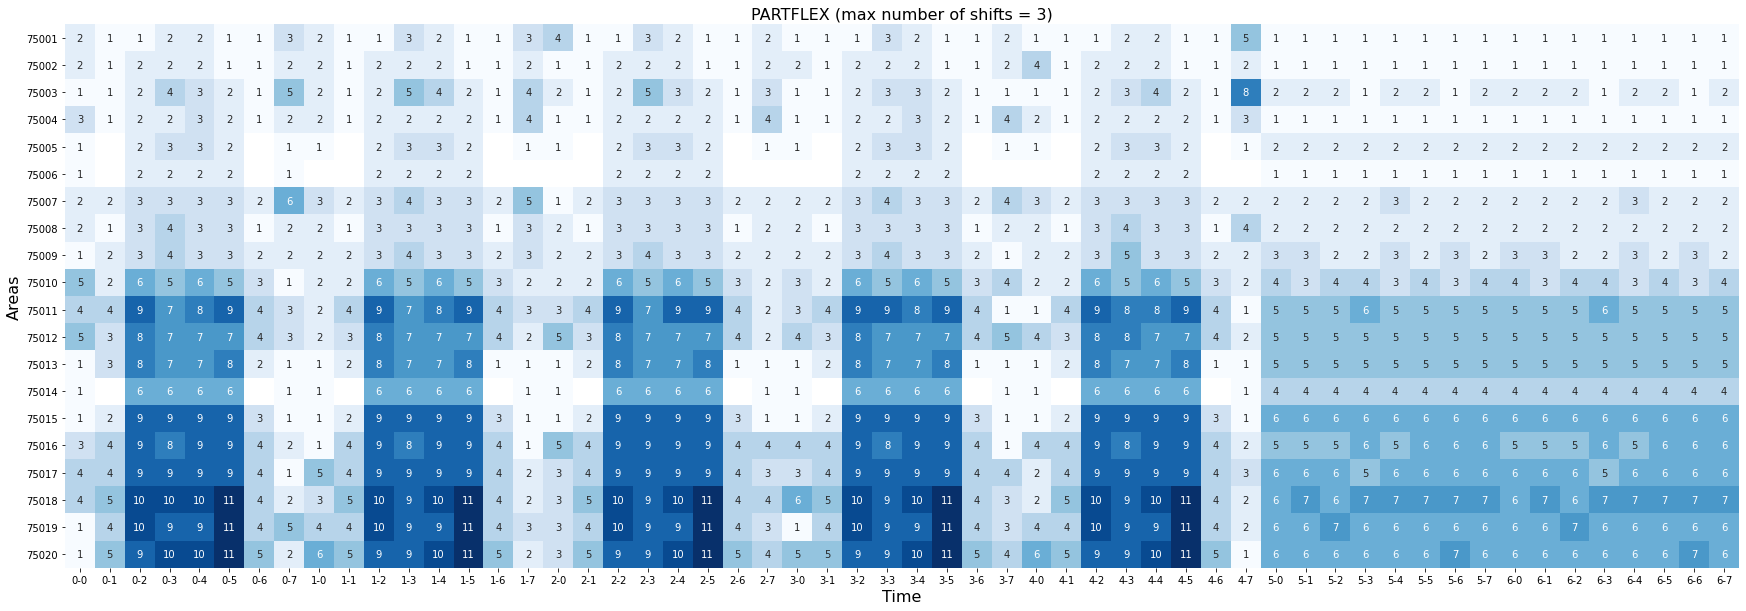

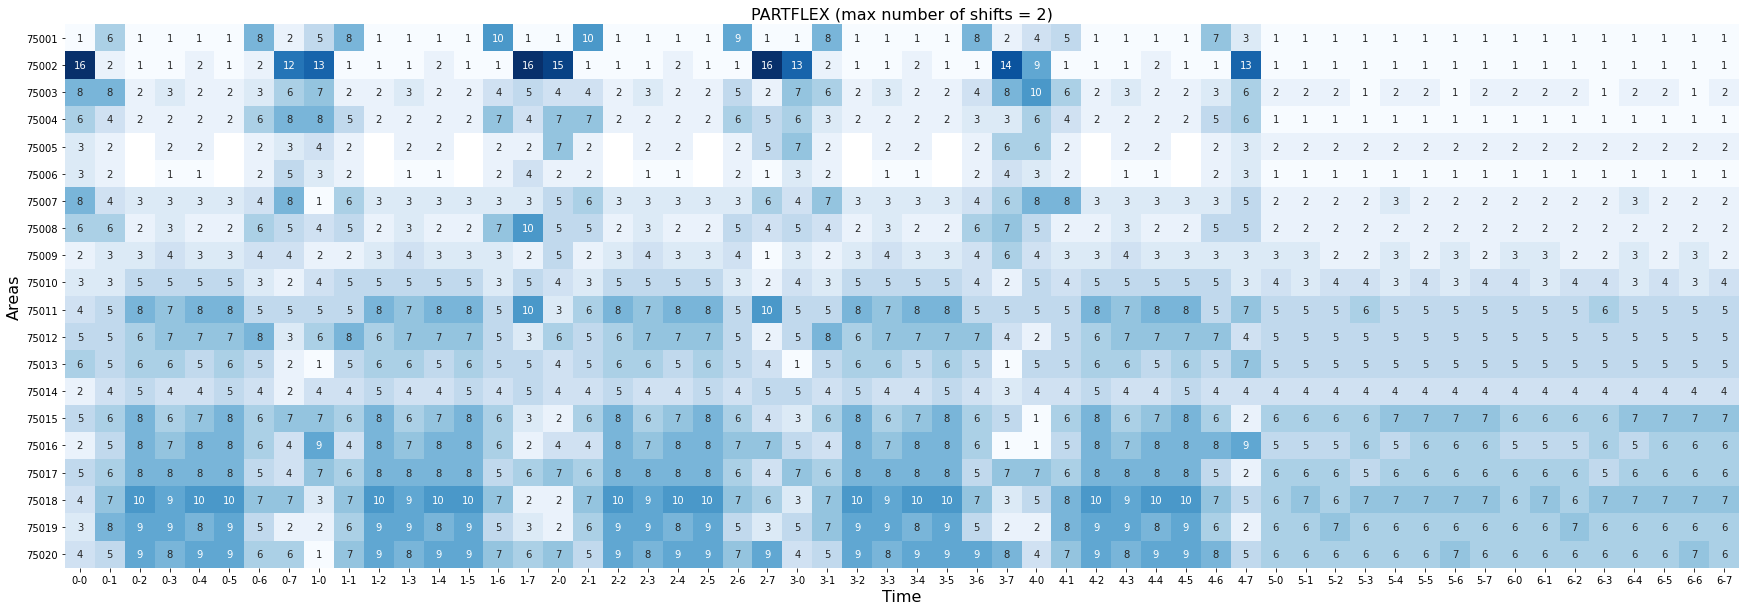

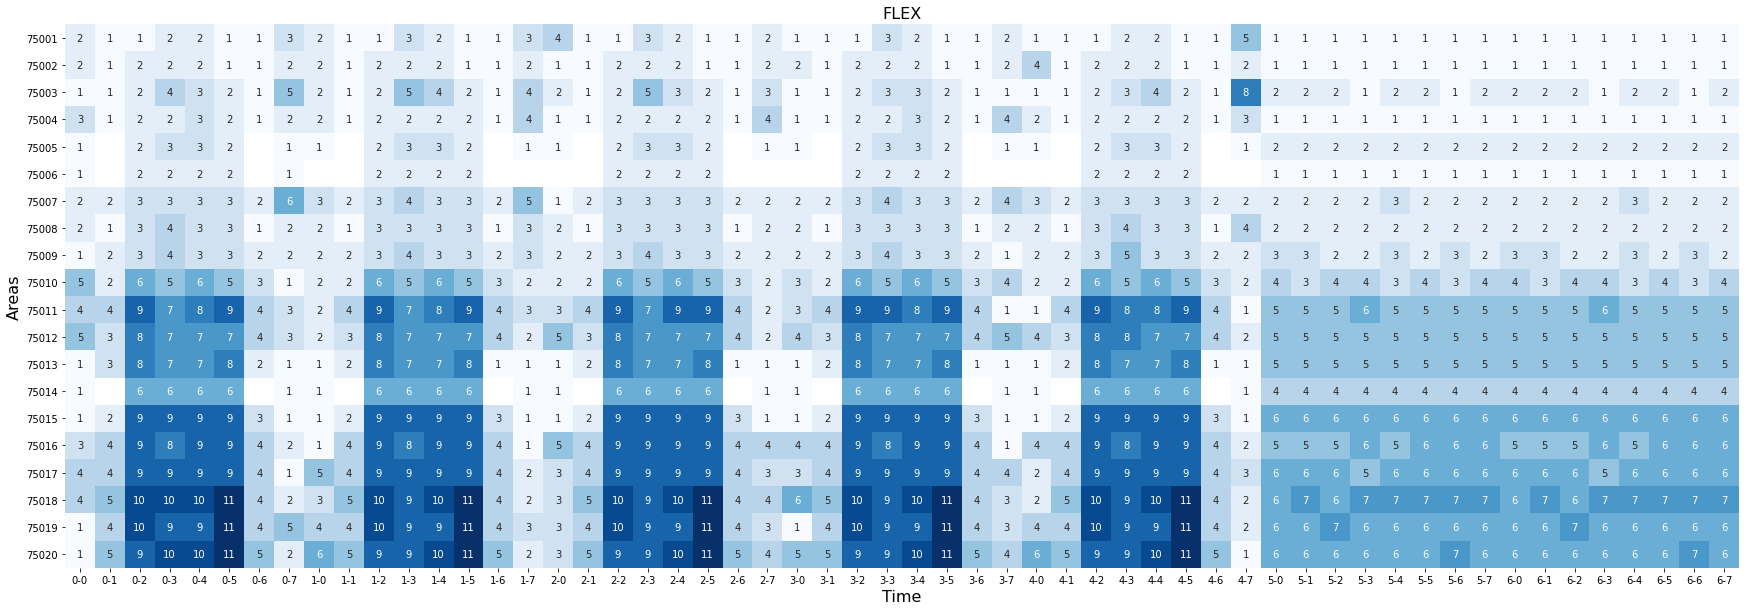

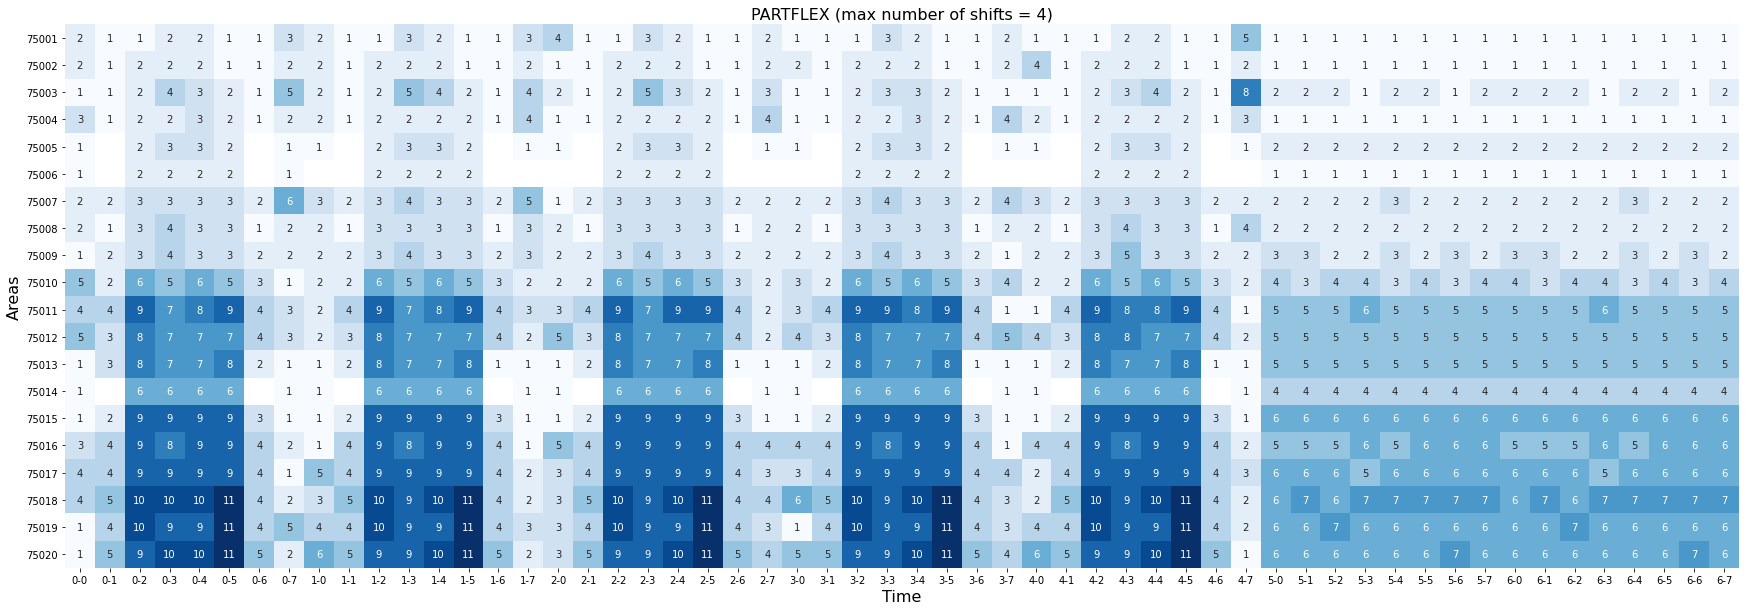

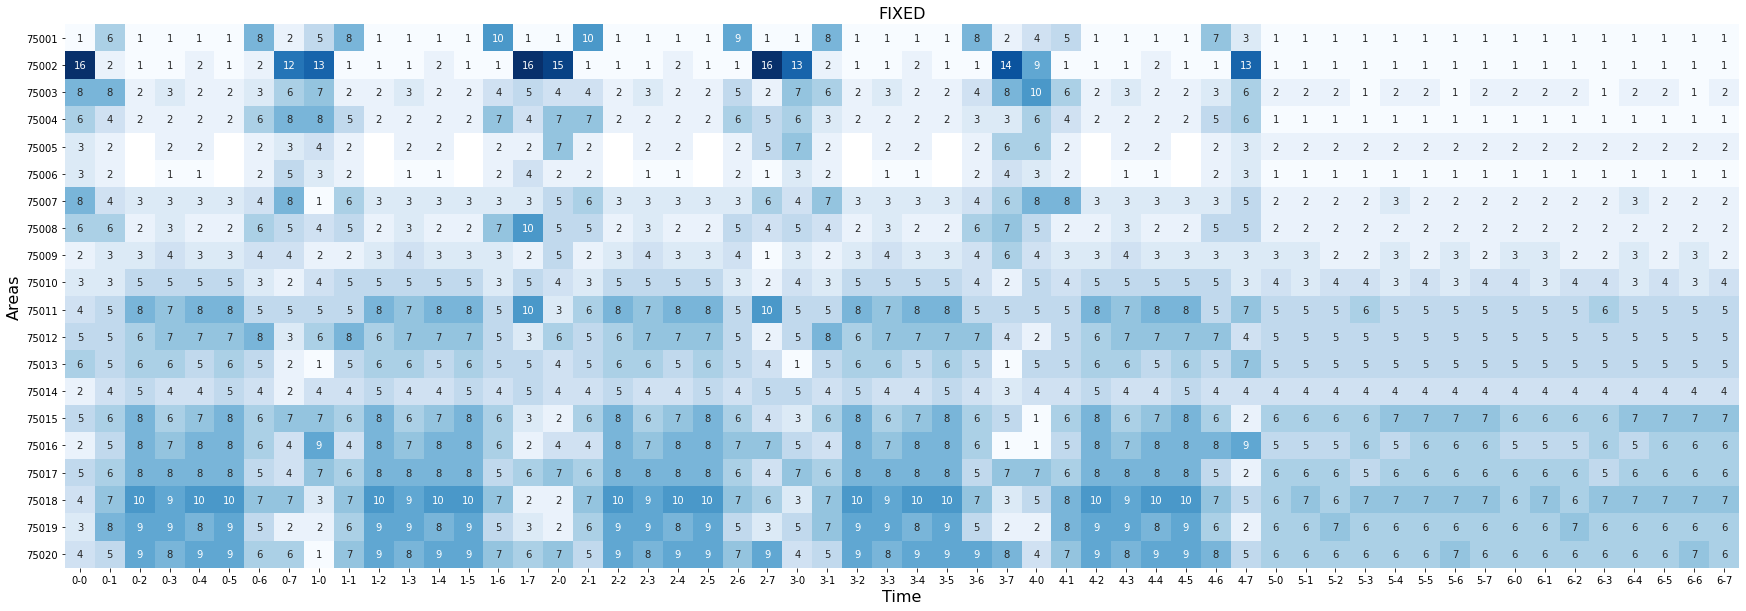

In [33]:
for solution_file in file_names:
    # Data preparation
    with open(f'{directory}/{solution_file}', 'rb') as file:
        solution = pickle.load(file)

    area_period_summary = data_prepare(solution)
    plot_area_periods(solution_file, area_period_summary)